In [ ]:
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from itertools import combinations 
from collections import OrderedDict
from tqdm import tqdm
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def seed_init():
    np.random.seed(0)
    random.seed(0)
    torch.manual_seed(0)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(0)
        torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# ref : https://discuss.pytorch.org/t/random-seed-initialization/7854/19

In [ ]:
seed_init()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/att_face_dataset/'

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, path, transform=transforms.ToTensor()):
        self.dirs = glob.glob(f'{path}*/')
        self.transform = transform
        
        self.total_images = self._get_images(self.dirs, self.transform)

    def _get_images(self, dirs, transform):
        ti = []
        for dir in tqdm(dirs):
#             images = [transform(Image.open(image)).squeeze() for image in glob.glob(f'{dir}*')]
            images = [transform(Image.open(image)) for image in glob.glob(f'{dir}*')]
            ti.append(images)
        return ti
        
    def __len__(self):
        return self.dirs.__len__()
    
    def __getitem__(self,idx):
        return torch.stack(self.total_images[idx], dim=0)
# ref : https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [ ]:
process = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.4422, std=0.1931),
])

# dataset = list(att_dataset)
# torch.cat(dataset).mean() , torch.cat(dataset).std()
# #  (tensor(0.4417), tensor(0.1958))

In [ ]:
att_dataset = CustomDataset(PATH, transform=process)

 48%|████▊     | 19/40 [00:44<00:48,  2.31s/it]

In [197]:
att_dataset[0][0].shape

torch.Size([1, 224, 224])

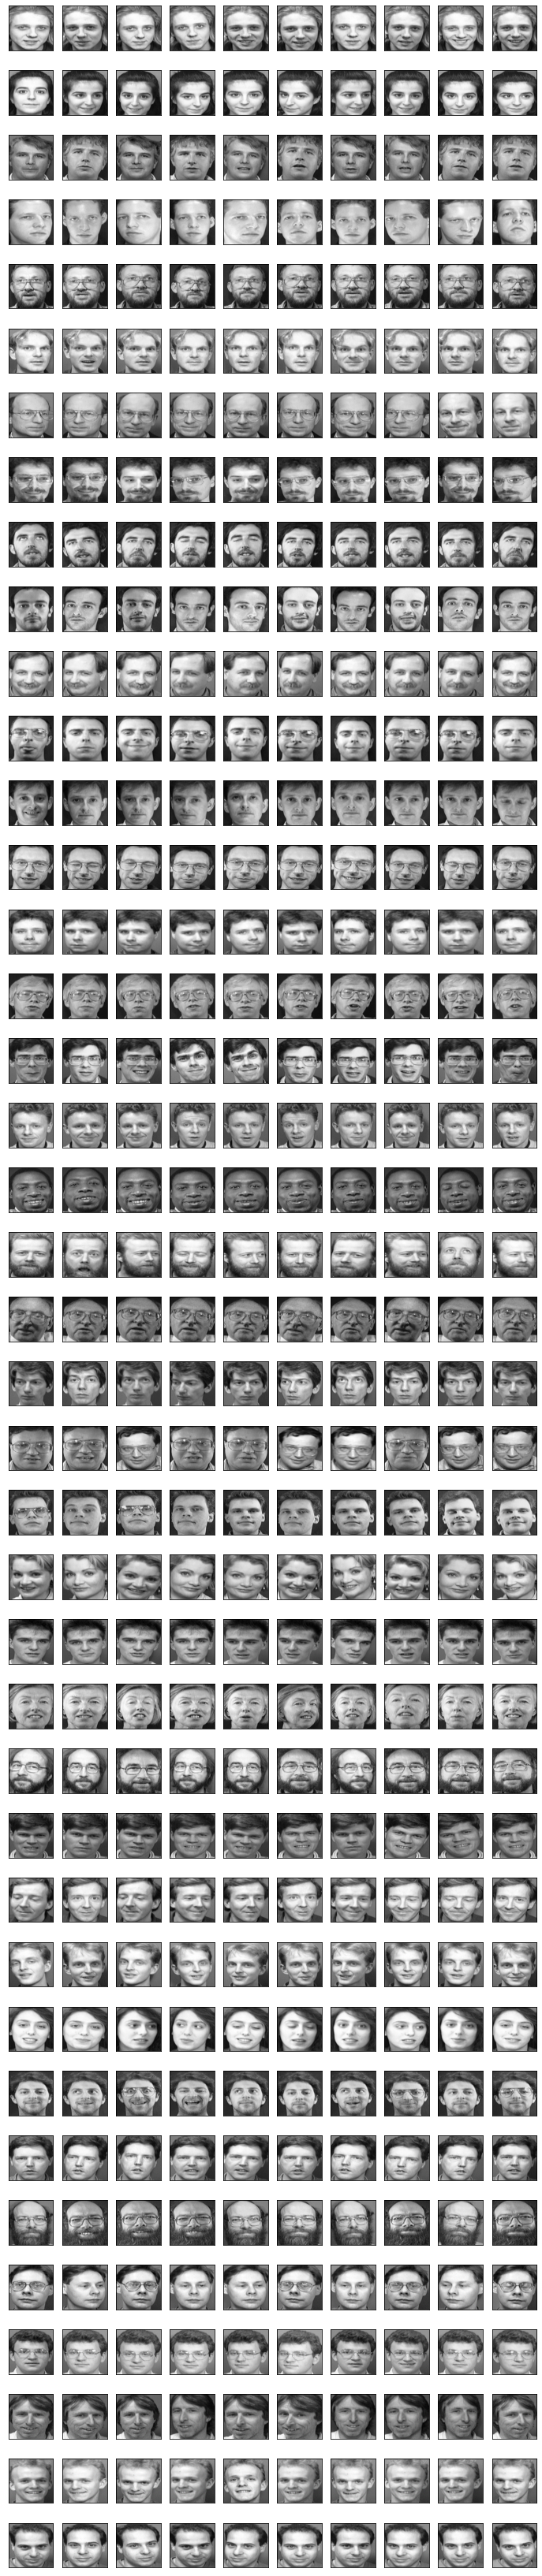

In [ ]:
_,axxr = plt.subplots(40,10, figsize=(12,60))
for i in range(40):
    for j in range(10):
        axxr[i][j].imshow(att_dataset[i][j].squeeze(), cmap='gray')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
plt.show()

In [ ]:
dataset = list(att_dataset)
torch.cat(dataset).mean() , torch.cat(dataset).std()
#  (tensor(0.4417), tensor(0.1958))

In [ ]:
def triplet_loss(anchor, positive, negative, margin=1):
    pos_dist = (anchor - positive).pow(2).sum(-1) #.pow(.5)
    neg_dist = (anchor - negative).pow(2).sum(-1) #.pow(.5)
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()
 
# ref: https://github.com/adambielski/siamese-triplet/blob/master/losses.py#L24

In [ ]:
def get_random_triplets(embeddings,  targets=None) -> torch.Tensor:
    '''
    For each image in data (Anchor), randomly sample a Positive image from its class.  
    Then from each of the other classes sample one image (randomly) as the Negative. Hence, for every Anchor
    you will have 1 randomly selected positive from it's class and randomly selected Negative from each of the n-1 classes 
    where n is total number of classes.  For every Anchor image you would have n-1 triplets.
    So if you're having 3 classes of 10 images each then you would have 60 triplets. 
    '''


#     assert len(embeddings) == len(targets) , "Embeddings and Targets must have same lenght"

    triplets = []
    for i, embedding in enumerate(embeddings):
        temp = embeddings.pop(i)

        for anchor in embedding:
            positive = random.choice(embedding)

            for negatives in embeddings:
                negative = random.choice(negatives)

                triplets.append(torch.stack([anchor, positive, negative], dim=0))

        embeddings.insert(i, temp)

    return torch.stack(triplets, dim=0)

In [ ]:
def dist(enc1,enc2):
    return (enc1 - enc2).pow(2).sum(-1).pow(.5)

In [ ]:
triplets = get_random_triplets(dataset[:3])

In [ ]:
triplets.shape

torch.Size([60, 3, 1, 224, 224])

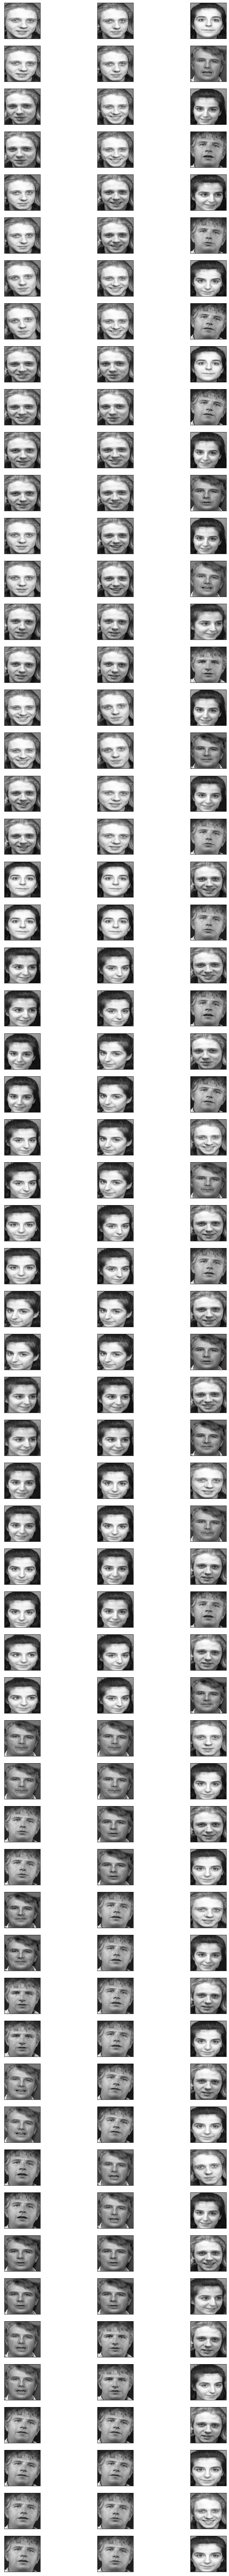

In [ ]:
_,axxr = plt.subplots(60,3, figsize=(12,120))
for i in range(60):
    for j in range(3):
        axxr[i][j].imshow(triplets[i][j].squeeze(), cmap='gray')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
plt.show()

In [ ]:
train = dataset[0:30]

In [ ]:
len(train)

In [ ]:
test = dataset[30:]

In [ ]:
len(test)

In [ ]:
class IdentityBlock(nn.Module):

    def __init__(self, n :int):
        super(IdentityBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=n, out_channels=n, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=n)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=n, out_channels=n, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=n)

    def forward(self, x):
        x_shortcut = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = x + x_shortcut
        x = self.relu(x)

        return x

# Ref : https://github.com/ABD-01/MNIST/blob/DL-Coursera/Course%204%20Convolutional%20Neural%20Network/Week%202%20ResNets/Residual_Networks_v2a.ipynb
# Ref : https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L37

In [ ]:
class ConvolutionalBlock(nn.Module):

    def __init__(self, n_in :int , n_out :int ):
        super(ConvolutionalBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=n_out)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=n_out, out_channels=n_out, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=n_out)

        self.downsample = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=1, stride=2, padding=0, bias=False)),
            ('bn', nn.BatchNorm2d(num_features=n_out))
        ]))


    def forward(self, x):
        x_shortcut = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x_shortcut = self.downsample(x_shortcut)

        x = x + x_shortcut
        x = self.relu(x)

        return x

# Ref : https://github.com/ABD-01/MNIST/blob/DL-Coursera/Course%204%20Convolutional%20Neural%20Network/Week%202%20ResNets/Residual_Networks_v2a.ipynb
# From the paper we can see that there are 2 options for matching the output size. Either padding the input volume or perform 1x1 convolutions. 
# Ref : https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8

In [ ]:
class ResidualBlock(nn.Module):
    
    def __init__(self, n_in :int , n_out :int , stride :int = 1, use_1x1conv=False):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=n_out)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=n_out, out_channels=n_out, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=n_out)

        if use_1x1conv:
            self.downsample = nn.Sequential(OrderedDict([
                ('conv', nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=1, stride=stride, padding=0, bias=False)),
                ('bn', nn.BatchNorm2d(num_features=n_out))
            ]))
        else:
            self.downsample = None


    def forward(self, x):
        x_shortcut = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample:
            x_shortcut = self.downsample(x_shortcut)

        x = x + x_shortcut
        x = self.relu(x)

        return x

# ref : https://d2l.ai/chapter_convolutional-modern/resnet.html
# ref : https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L144

In [ ]:
class ResNet(nn.Module):

    def __init__(self, layers = [2,2,2,2]):
        # resnet18 : layers = [2, 2, 2, 2]
        # resnet34 : layers = [3, 4, 6, 3]
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = nn.Sequential(
            self._make_layer(in_channels = 64, out_channels = 64, num_residuals = layers[0])                                 
        )
                            
        self.layer2 = nn.Sequential(
            self._make_layer(in_channels = 64, out_channels = 128, num_residuals = layers[1], reduce_dim = True) 
         )

        self.layer3 = nn.Sequential(
            self._make_layer(in_channels = 128, out_channels = 256, num_residuals = layers[2], reduce_dim = True) 
        )
                            
        self.layer4 = nn.Sequential(
            self._make_layer(in_channels = 256, out_channels = 512, num_residuals = layers[3], reduce_dim = True) 
        )
            
        self.avgpool = nn.AvgPool2d(kernel_size=7)
        # self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Sequential(
            nn.Linear(in_features=512*1, out_features=128),
            nn.ReLU(inplace=True)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, in_channels:int, out_channels:int, num_residuals: int, reduce_dim = False):
        block_layers = []
        for i in range(num_residuals):
            if i == 0 and reduce_dim:
                block_layers.append((f'block{i+1}', ResidualBlock(n_in = in_channels, n_out = out_channels, stride=2, use_1x1conv = True)))
            else:
                block_layers.append((f'block{i+1}', ResidualBlock(n_in = out_channels, n_out = out_channels)))

        return OrderedDict( block_layers )
    
    # ref : https://d2l.ai/chapter_convolutional-modern/resnet.html


    def semi_forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(input=x, start_dim=1) # ref : https://pytorch.org/docs/stable/generated/torch.flatten.html
        x = self.fc(x)
        return x

    def forward(self,triplet):
        anc = self.semi_forward(triplet[:,0,...])
        pos = self.semi_forward(triplet[:,1,...])
        neg = self.semi_forward(triplet[:,2,...])
        return [anc, pos, neg]

# ref : https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8

In [ ]:
class ResNet18(nn.Module):

    def __init__(self):
        super(ResNet18, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = nn.Sequential(OrderedDict([
            ('block1', IdentityBlock(n = 64)),
            ('block2', IdentityBlock(n = 64))
        ]))
                            
        self.layer2 = nn.Sequential(OrderedDict([
            ('block1', ConvolutionalBlock(n_in = 64, n_out = 128)),
            ('block2', IdentityBlock(n = 128))
        ]))

        self.layer3 = nn.Sequential(OrderedDict([
            ('block1', ConvolutionalBlock(n_in = 128, n_out = 256)),
            ('block2', IdentityBlock(n = 256))
        ]))
                            
        self.layer4 = nn.Sequential(OrderedDict([
            ('block1', ConvolutionalBlock(n_in = 256, n_out = 512)),
            ('block2', IdentityBlock(n = 512))
        ]))
            
        self.avgpool = nn.AvgPool2d(kernel_size=7)
        # self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Sequential(
            nn.Linear(in_features=512*1, out_features=128),
            nn.ReLU(inplace=True)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def semi_forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(input=x, start_dim=1) # ref : https://pytorch.org/docs/stable/generated/torch.flatten.html
        x = self.fc(x)
        return x

    def forward(self,triplet):
        anc = self.semi_forward(triplet[:,0,...])
        pos = self.semi_forward(triplet[:,1,...])
        neg = self.semi_forward(triplet[:,2,...])
        return [anc, pos, neg]

# ref : https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8

In [ ]:
class RESNET18(nn.Module):
    def __init__(self):
        super(RESNET18, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=1, stride=1, padding=0, bias=False),
            torchvision.models.resnet18(pretrained=False),
            nn.Linear(1000, 128)
        )
    def semi_forward(self, x):
        return self.model(x)

    def forward(self,triplet):
        anc = self.semi_forward(triplet[:,0,...])
        pos = self.semi_forward(triplet[:,1,...])
        neg = self.semi_forward(triplet[:,2,...])
        return [anc, pos, neg] 

In [ ]:
resnet18 = ResNet()

t = torch.rand(10,1,224,224)
print('rand', t.shape)
t = resnet18.conv1(t)
print('conv1', t.shape)
t = resnet18.maxpool(t)
print('maxpool', t.shape)
t = resnet18.layer1(t)
print('layer1', t.shape)
t = resnet18.layer2(t)
print('layer2', t.shape)
t = resnet18.layer3(t)
print('layer3', t.shape)
t = resnet18.layer4(t)
print('layer4', t.shape)
t = resnet18.avgpool(t)
print('avgpool', t.shape)
t = torch.flatten(t,1)
print('flatten', t.shape)
t = resnet18.fc(t)
print('fc', t.shape)

In [ ]:
resnet18 = ResNet18()
# resnet18

In [ ]:
t = torch.rand(10,1,224,224)
print('rand', t.shape)
t = resnet18.conv1(t)
print('conv1', t.shape)
t = resnet18.maxpool(t)
print('maxpool', t.shape)
t = resnet18.layer1(t)
print('layer1', t.shape)
t = resnet18.layer2(t)
print('layer2', t.shape)
t = resnet18.layer3(t)
print('layer3', t.shape)
t = resnet18.layer4(t)
print('layer4', t.shape)
t = resnet18.avgpool(t)
print('avgpool', t.shape)
t = torch.flatten(t,1)
print('flatten', t.shape)
t = resnet18.fc(t)
print('fc', t.shape)

rand torch.Size([10, 1, 224, 224])
conv1 torch.Size([10, 64, 112, 112])
maxpool torch.Size([10, 64, 56, 56])
layer1 torch.Size([10, 64, 56, 56])
layer2 torch.Size([10, 128, 28, 28])
layer3 torch.Size([10, 256, 14, 14])
layer4 torch.Size([10, 512, 7, 7])
avgpool torch.Size([10, 512, 1, 1])
flatten torch.Size([10, 512])
fc torch.Size([10, 128])


In [ ]:
resnet18 = RESNET18()

t = torch.rand(10,1,224,224)
print('rand', t.shape)
t = resnet18.semi_forward(t)
print('Inbuilt', t.shape)

rand torch.Size([10, 1, 224, 224])
Inbuilt torch.Size([10, 128])


In [ ]:
t = torch.rand(100,3,1,224,224)
print('rand', t.shape)
t = resnet18(t)
print('resnet18', t[0].shape, t[1].shape, t[2].shape)

rand torch.Size([100, 3, 1, 224, 224])
resnet18 torch.Size([100, 128]) torch.Size([100, 128]) torch.Size([100, 128])


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
count_parameters(resnet18)

In [ ]:
def Train(model, batch, loss_fn, optimizer, cost):
    model.train()

    apn = model(batch.cuda())

    optimizer.zero_grad()
    loss = loss_fn(*apn)
    cost.append(loss.item())
    loss.backward()
    optimizer.step()

    return cost[-1]

In [133]:
def Evaluate(model, batch):
    model.eval()
    def dist(enc1,enc2):
        return (enc1 - enc2).pow(2).sum(-1) #.pow(.5)
    with torch.no_grad():
        sample = torch.cat([model.semi_forward(imgs[0].unsqueeze(0).cuda()).cpu() for imgs in batch])
        total_enc = [model.semi_forward(img.cuda()).cpu() for img in batch]
        
        pred = [torch.stack([dist(enc,sample).argmin() for enc in total_enc[i]]) for i in range(len(total_enc))]
        # acc = sum([(pred[i] == i).sum() for i in range(len(total_enc))])
        del total_enc
    # return (acc.item() / (len(batch) * 10) )
    return torch.stack(pred)

In [164]:
resnet18 = ResNet()

In [ ]:
torch.set_grad_enabled(True)
resnet18.train(True)

In [166]:
learning_rate = 0.0001
optimizer = optim.Adam(resnet18.parameters(), lr = learning_rate)
torch_triplet_loss = nn.TripletMarginLoss()
if torch.cuda.is_available():
    resnet18 = resnet18.cuda()

In [ ]:
cost = []
train_acc = []
test_acc = []
total_acc = []
epochs = 10
for epoch in range(epochs):

    triplets = get_random_triplets(train)
    loader = DataLoader(triplets, batch_size=100)
    for i,batch in enumerate(loader):

        apn = resnet18(batch.cuda())

        optimizer.zero_grad()
        loss = triplet_loss(*apn)
        cost.append(loss.item())

        loss.backward()
        optimizer.step()

        ####
        with torch.no_grad():
            resnet18.train(False)
            sample = torch.cat([resnet18.semi_forward(att_dataset[i][0].unsqueeze(0).cuda()).cpu() for i in range(40)])
            total_enc = [resnet18.semi_forward(img.cuda()).cpu() for img in dataset]
            pred = [torch.stack([dist(enc,sample).argmin() for enc in total_enc[i]]) for i in range(40)]
            acc1 = sum([(pred[i] == i).sum() for i in range(0,30)])
            acc2 = sum([(pred[i] == i).sum() for i in range(30,40)])
            train_acc.append(acc1.item()  / 300)
            test_acc.append(acc2.item() / 100)
            total_acc.append((acc1.item() + acc2.item()) / 400 )
            del total_enc
            resnet18.train(True)
        ####

        if (i+1)%20==0 :
            print(f'Epoch:[{epoch+1}/{epochs}], Step:[{i+1}/87]', 'Cost : {:.2f}, Train Acc: {:.2f}, Test Acc: {:.2f}'.format(loss.item(), acc1.item()/3, acc2.item()))
            # print(f'Epoch:[{epoch+1}/{epochs}], Step:[{i+1}] Cost : {loss.item()}')

In [167]:
cost = [float('inf')]
train_acc = [0]
test_acc = [0]
epochs = 20
for epoch in range(epochs):

    triplets = get_random_triplets(train)
    loader = DataLoader(triplets, batch_size=100)
    for i,batch in enumerate(loader):

        loss = Train(resnet18, batch, triplet_loss, optimizer, cost)
        
        # pred = Evaluate(resnet18, train)
        # acc1 = ( (pred == torch.arange(len(pred)).reshape(-1,1)).sum() / (len(pred)*10) ).item()
        # train_acc.append(acc1)

        # pred = Evaluate(resnet18, test)
        # acc2 = ( (pred == torch.arange(len(pred)).reshape(-1,1)).sum() / (len(pred)*10) ).item()
        # test_acc.append(acc2)

        if (i+1)%20==0 :
            # print(f'Epoch:[{epoch+1}/{epochs}], Step:[{i+1}/87]', 'Cost : {:.2f}, Train Acc: {:.2f}, Test Acc: {:.2f}'.format(loss, acc1, acc2))
            print(f'Epoch:[{epoch+1}/{epochs}], Step:[{i+1}/87]', 'Cost : {:.2f}'.format(loss))

Epoch:[1/20], Step:[20/87] Cost : 0.11
Epoch:[1/20], Step:[40/87] Cost : 0.01
Epoch:[1/20], Step:[60/87] Cost : 0.02
Epoch:[1/20], Step:[80/87] Cost : 1.12
Epoch:[2/20], Step:[20/87] Cost : 0.66
Epoch:[2/20], Step:[40/87] Cost : 0.00
Epoch:[2/20], Step:[60/87] Cost : 0.00
Epoch:[2/20], Step:[80/87] Cost : 0.02
Epoch:[3/20], Step:[20/87] Cost : 0.00
Epoch:[3/20], Step:[40/87] Cost : 0.00
Epoch:[3/20], Step:[60/87] Cost : 0.00
Epoch:[3/20], Step:[80/87] Cost : 0.02
Epoch:[4/20], Step:[20/87] Cost : 0.07
Epoch:[4/20], Step:[40/87] Cost : 0.00
Epoch:[4/20], Step:[60/87] Cost : 0.01
Epoch:[4/20], Step:[80/87] Cost : 2.02
Epoch:[5/20], Step:[20/87] Cost : 0.01
Epoch:[5/20], Step:[40/87] Cost : 0.07
Epoch:[5/20], Step:[60/87] Cost : 0.01
Epoch:[5/20], Step:[80/87] Cost : 0.08
Epoch:[6/20], Step:[20/87] Cost : 0.00
Epoch:[6/20], Step:[40/87] Cost : 0.00
Epoch:[6/20], Step:[60/87] Cost : 0.00
Epoch:[6/20], Step:[80/87] Cost : 0.02
Epoch:[7/20], Step:[20/87] Cost : 0.01
Epoch:[7/20], Step:[40/87

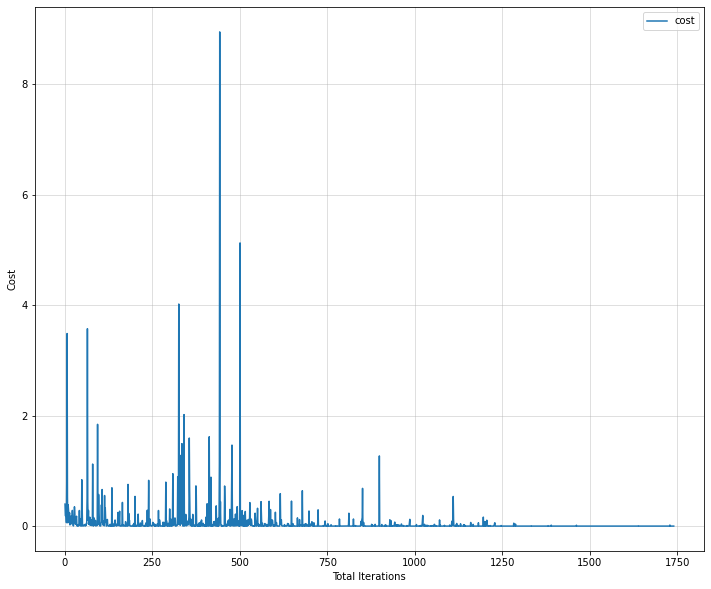

In [168]:
plt.figure(figsize=(12,10))
plt.xlabel('Total Iterations')
plt.ylabel('Cost')
plt.plot(np.arange(len(cost)), cost, label='cost')
plt.plot(np.arange(len(train_acc)), train_acc, label='train_acc')
plt.plot(np.arange(len(test_acc)), test_acc, label='test_acc')
plt.grid(alpha=0.5)
plt.legend()
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/siamese-orl-loss on 30classes(resnet)')
plt.show()

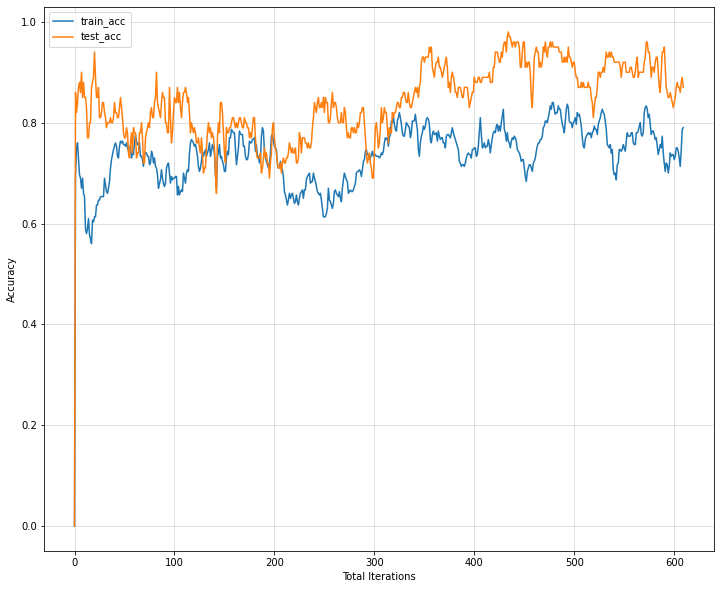

In [121]:
plt.figure(figsize=(12,10))
plt.xlabel('Total Iterations')
plt.ylabel('Accuracy')
plt.plot(np.arange(len(train_acc)), train_acc, label='train_acc')
plt.plot(np.arange(len(test_acc)), test_acc, label='test_acc')
plt.grid(alpha=0.5)
plt.legend()
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/siamese-orl-loss on 30classes(resnet)')
plt.show()

In [ ]:
torch.set_grad_enabled(False)
resnet18.train(False)

In [179]:
sample = torch.cat([resnet18.semi_forward(att_dataset[i][0].unsqueeze(0).cuda()).cpu() for i in tqdm(range(30))])

100%|██████████| 30/30 [00:00<00:00, 228.22it/s]


Actual Class: 20
Predicted Class: tensor(18)


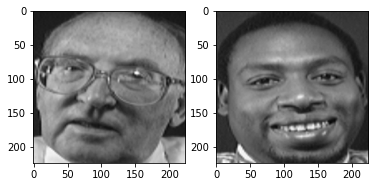

In [180]:
Class = 20
_,(i1,i2) = plt.subplots(1,2)
randImg = att_dataset[Class][5]
i1.imshow(randImg.squeeze(), cmap='gray')
renc = resnet18.semi_forward(randImg.unsqueeze(0).cuda()).cpu()
dis = dist(renc, sample)
print('Actual Class:', Class)
print('Predicted Class:',dis.argmin())
i2.imshow(att_dataset[dis.argmin().item()][0].squeeze(), cmap='gray')
plt.show()

In [178]:
total_enc = [resnet18.semi_forward(img.cuda()).cpu() for img in tqdm(dataset)]

100%|██████████| 40/40 [00:00<00:00, 41.83it/s]


In [ ]:
pred = [torch.stack([dist(enc,sample).argmin() for enc in total_enc[i]]) for i in range(40)]
print(*pred, sep='\n')

In [138]:
sum([(pred[i] == i).sum() for i in range(len(pred))]) / (len(pred) * 10) 

tensor(0.8700)

In [193]:
test_pred = Evaluate(resnet18, test)
test_acc = ( (test_pred == torch.arange(len(test_pred)).reshape(-1,1)).sum() / (len(test_pred)*10) ).item()

train_pred = Evaluate(resnet18, train)
train_acc = ( (train_pred == torch.arange(len(train_pred)).reshape(-1,1)).sum() / (len(train_pred)*10) ).item()

total_pred = Evaluate(resnet18, train)
total_acc = ( (total_pred == torch.arange(len(total_pred)).reshape(-1,1)).sum() / (len(total_pred)*10) ).item()

In [194]:
train_acc, test_acc, total_acc

(0.8700000047683716, 0.8199999928474426, 0.8199999928474426)

In [ ]:
torch.arange(len(torch.stack(pred))).reshape(-1,1)

tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9]])

In [183]:
test_pred

tensor([[0, 8, 0, 0, 8, 0, 8, 0, 0, 8],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3, 2, 3, 9, 3],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [5, 9, 5, 9, 5, 5, 5, 5, 5, 5],
        [6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
        [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
        [8, 0, 0, 8, 0, 8, 0, 8, 8, 0],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]])

In [184]:
train_pred

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
        [ 3,  3,  3,  3,  5,  0,  0,  5,  3,  3],
        [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
        [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5],
        [ 6,  6,  6,  6,  6,  6,  6,  6,  6, 19],
        [ 7,  7,  9,  7,  9,  7,  7,  7,  7,  7],
        [ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8],
        [ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9],
        [10, 10, 10, 10, 10, 10, 10, 29, 10, 10],
        [11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
        [12, 12, 12, 12, 12, 12, 12, 12, 12, 20],
        [13, 13, 13, 13, 13, 13, 13, 13, 13, 13],
        [14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
        [15, 15, 15, 15, 15, 15, 15, 15, 15, 15],
        [16, 16, 16, 16, 16, 16, 16, 16, 16, 16],
        [17, 25, 25, 17, 17, 25, 17, 25, 17, 17],
        [18, 18, 18, 18, 18, 18, 18, 18, 18, 18],
        [19, 19, 19, 19,  5, 19, 19, 19, 19,  5],


In [195]:
total_pred

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
        [ 3,  3,  3,  3,  5,  0,  0,  5,  3,  3],
        [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
        [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5],
        [ 6,  6,  6,  6,  6,  6,  6,  6,  6, 19],
        [ 7,  7,  9,  7,  9,  7,  7,  7,  7,  7],
        [ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8],
        [ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9],
        [10, 10, 10, 10, 10, 10, 10, 29, 10, 10],
        [11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
        [12, 12, 12, 12, 12, 12, 12, 12, 12, 20],
        [13, 13, 13, 13, 13, 13, 13, 13, 13, 13],
        [14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
        [15, 15, 15, 15, 15, 15, 15, 15, 15, 15],
        [16, 16, 16, 16, 16, 16, 16, 16, 16, 16],
        [17, 25, 25, 17, 17, 25, 17, 25, 17, 17],
        [18, 18, 18, 18, 18, 18, 18, 18, 18, 18],
        [19, 19, 19, 19,  5, 19, 19, 19, 19,  5],


In [191]:
acc = []
pred = train_pred
for i in range(len(pred)):
    corr = (pred[i] == i).sum()
    print(f'(Claas {i})', corr.item(), 'out of 10')
    acc.append(corr.item())

print('Accuracy = ', sum(acc) / (len(pred)*10))


#@markdown Train Accuracy =82.0 %   

#@markdown Test Accuracy =  87.0 %  

#@markdown Total Accuracy =  88.0 %  


(Claas 0) 10 out of 10
(Claas 1) 10 out of 10
(Claas 2) 10 out of 10
(Claas 3) 6 out of 10
(Claas 4) 10 out of 10
(Claas 5) 10 out of 10
(Claas 6) 9 out of 10
(Claas 7) 8 out of 10
(Claas 8) 10 out of 10
(Claas 9) 10 out of 10
(Claas 10) 9 out of 10
(Claas 11) 10 out of 10
(Claas 12) 9 out of 10
(Claas 13) 10 out of 10
(Claas 14) 10 out of 10
(Claas 15) 10 out of 10
(Claas 16) 10 out of 10
(Claas 17) 6 out of 10
(Claas 18) 10 out of 10
(Claas 19) 8 out of 10
(Claas 20) 2 out of 10
(Claas 21) 5 out of 10
(Claas 22) 7 out of 10
(Claas 23) 8 out of 10
(Claas 24) 5 out of 10
(Claas 25) 5 out of 10
(Claas 26) 9 out of 10
(Claas 27) 6 out of 10
(Claas 28) 10 out of 10
(Claas 29) 4 out of 10
Accuracy =  0.82


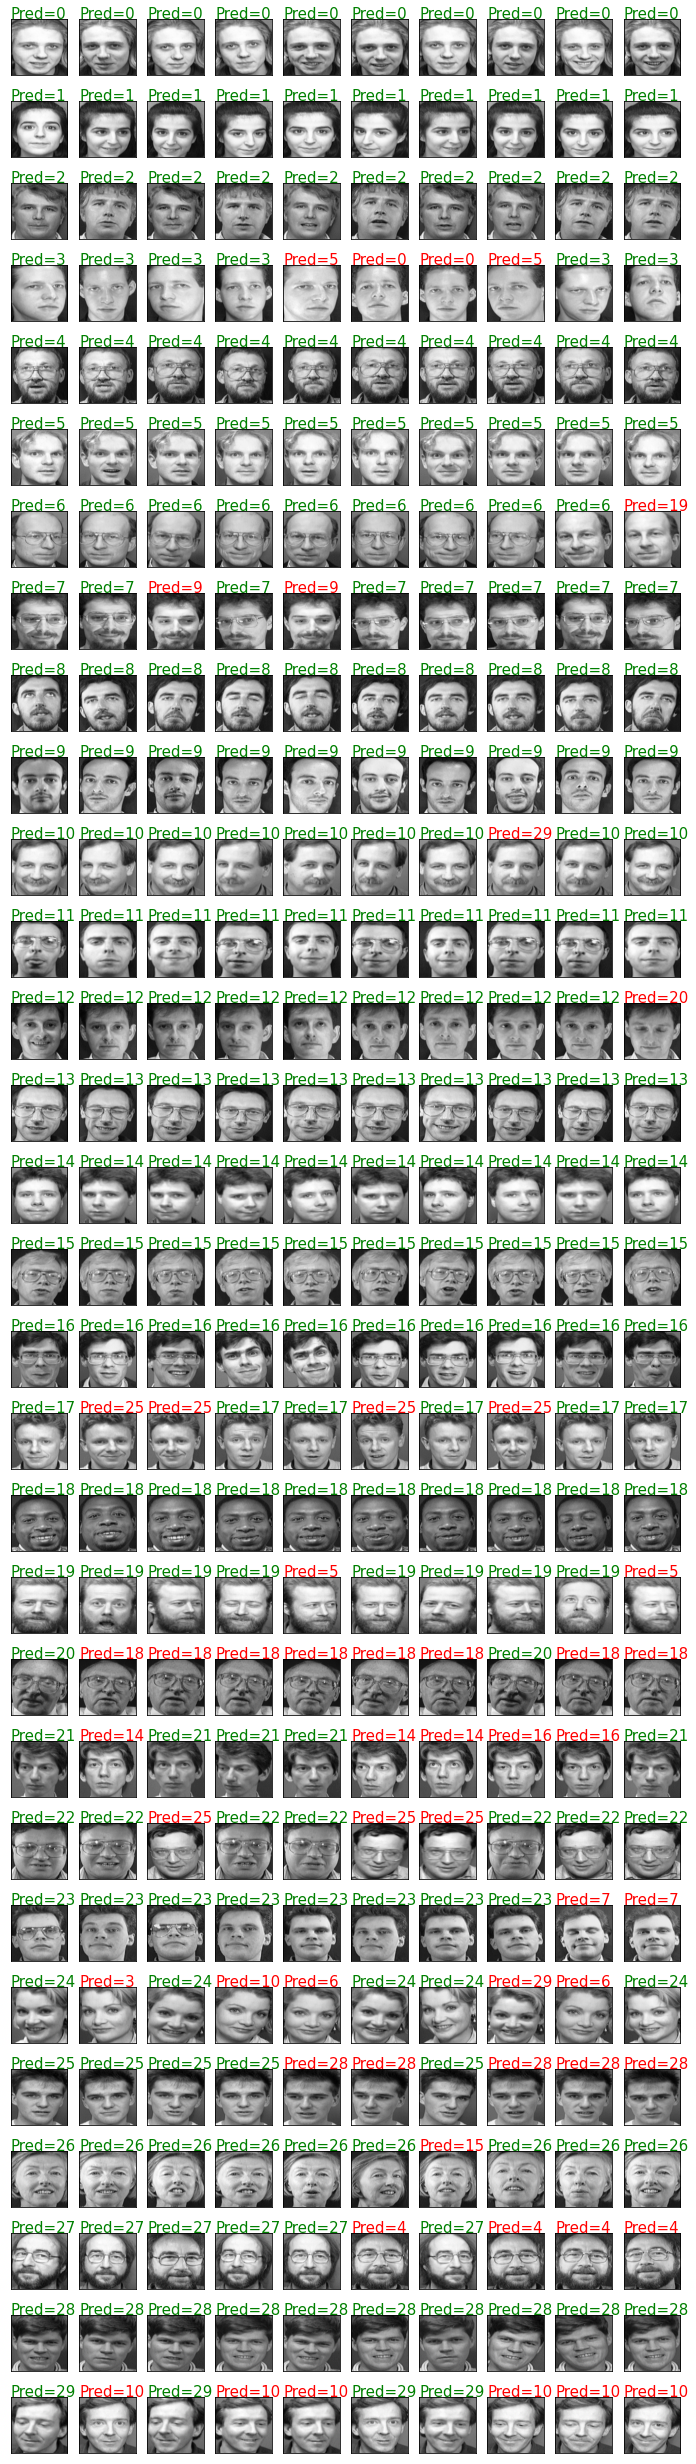

In [189]:
_,axxr = plt.subplots(len(train_pred),10, figsize=(12,len(train_pred)*1.5))
for i in range(len(train_pred)):
    for j in range(10):
        axxr[i][j].imshow(train[i][j].squeeze(), cmap='gray')
        if train_pred[i][j] == i:
            axxr[i][j].text(0.5,1,f'Pred={i}', color='green', fontsize=15)
        else:
            axxr[i][j].text(0.5,1,f'Pred={train_pred[i][j].item()}', color='red', fontsize=15)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/prediction_results of all 40 classes(resnet).png', dpi=200)
plt.show()

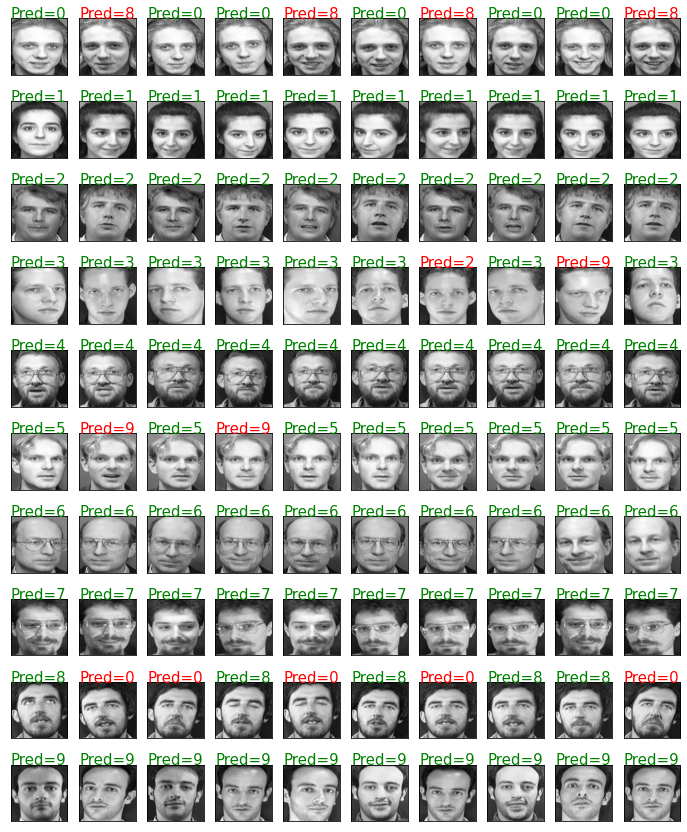

In [188]:
_,axxr = plt.subplots(len(test_pred),10, figsize=(12,len(test_pred)*1.5))
for i in range(len(test_pred)):
    for j in range(10):
        axxr[i][j].imshow(train[i][j].squeeze(), cmap='gray')
        if test_pred[i][j] == i:
            axxr[i][j].text(0.5,1,f'Pred={i}', color='green', fontsize=15)
        else:
            axxr[i][j].text(0.5,1,f'Pred={test_pred[i][j].item()}', color='red', fontsize=15)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/prediction_results of all 40 classes(resnet).png', dpi=200)
plt.show()

In [169]:
# Saving the state_dict of Model
PATH = '/content/drive/MyDrive/Colab Notebooks/siamese-orl(resnet)3'

In [170]:
torch.save(resnet18.state_dict(), PATH)

In [ ]:
resnet18.load_state_dict(torch.load(PATH,  map_location=torch.device('cpu')))
resnet18.eval()